# Car Price Prediction - Linear Regression Example

This notebook demonstrates a complete machine learning workflow for predicting car prices using linear regression. We'll cover:
- Data loading and preparation
- Exploratory data analysis
- Training/validation/test split
- Linear regression implementation
- Feature engineering
- Model validation using RMSE
- Regularization and hyperparameter tuning

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Loading and Preparation

First, let's load our car price dataset and prepare it for analysis.

In [ ]:
# Define the URL for our dataset
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [ ]:
# Download the data using wget
!wget $data -O data.csv

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('data.csv')

# Display the column names to see what features we have
print("Original column names:")
print(df.columns)

# Clean up column names:
# - Convert to lowercase
# - Replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

print("\nCleaned column names:")
print(df.columns)

--2025-10-03 19:51:21--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.1s    

2025-10-03 19:51:21 (13.3 MB/s) - ‘data.csv’ saved [1475504/1475504]

Original column names:
Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

Cleaned column names:
Index(['make', 'model', 'year', 'engine_fu

In [8]:
df['make'].str.lower().str.replace(' ', '_')

0            bmw
1            bmw
2            bmw
3            bmw
4            bmw
          ...   
11909      acura
11910      acura
11911      acura
11912      acura
11913    lincoln
Name: make, Length: 11914, dtype: object

In [9]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [10]:
# Columns with strings types
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

## Exploratory Data Analysis (EDA)

Let's explore our dataset to better understand our features and target variable (MSRP - car price).

In [11]:
# Display information about each column in our dataset
print("Column information:")
for col in df.columns:
    print(f"\nColumn: {col}")
    print(f"First 5 unique values: {df[col].unique()[:5]}")
    print(f"Number of unique values: {df[col].nunique()}")
    print("-" * 50)

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Column information:

Column: make
First 5 unique values: ['BMW' 'Audi' 'FIAT' 'Mercedes-Benz' 'Chrysler']
Number of unique values: 48
--------------------------------------------------

Column: model
First 5 unique values: ['1 Series M' '1 Series' '100' '124 Spider' '190-Class']
Number of unique values: 915
--------------------------------------------------

Column: year
First 5 unique values: [2011 2012 2013 1992 1993]
Number of unique values: 28
--------------------------------------------------

Column: engine_fuel_type
First 5 unique values: ['premium unleaded (required)' 'regular unleaded'
 'premium unleaded (recommended)' 'flex-fuel (unleaded/E85)' 'diesel']
Number of unique values: 10
--------------------------------------------------

Column: engine_hp
First 5 unique values: [335. 300. 230. 320. 172.]
Number of unique values: 356
--------------------------------------------------

Column: engine_cylinders
First 5 unique values: [ 6.  4.  5.  8. 12.]
Number of unique values: 9
-

In [13]:
df

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


Distribution of price

<Axes: xlabel='msrp', ylabel='Count'>

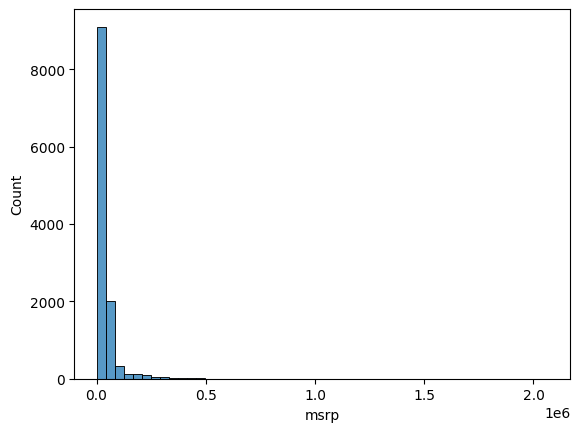

In [15]:
sns.histplot(df.msrp, bins=50)

<Axes: xlabel='msrp', ylabel='Count'>

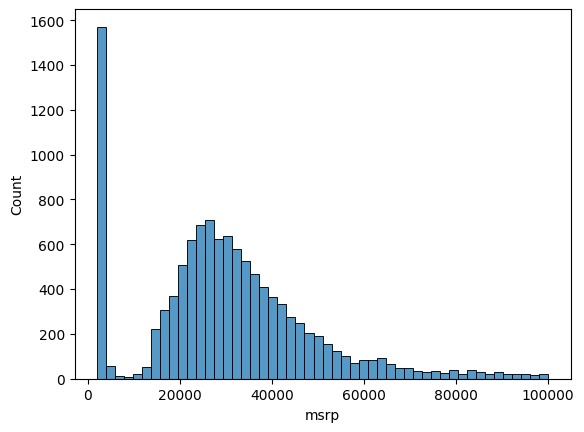

In [16]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)

In [17]:
np.log1p([0, 1, 10, 1000, 100000])

array([ 0.        ,  0.69314718,  2.39789527,  6.90875478, 11.51293546])

In [18]:
np.log([0 + 1, 1+ 1, 10 + 1, 1000 + 1, 100000])

array([ 0.        ,  0.69314718,  2.39789527,  6.90875478, 11.51292546])

In [19]:
price_logs = np.log1p(df.msrp)

<Axes: xlabel='msrp', ylabel='Count'>

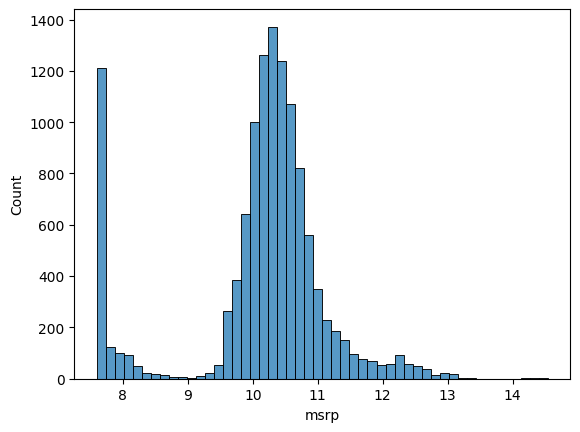

In [20]:
sns.histplot(price_logs, bins=50)

Missing values

## Data Splitting

We'll split our data into three sets:
- Training set (60%): Used to train the model
- Validation set (20%): Used to tune hyperparameters
- Test set (20%): Used for final model evaluation

## 2.4 Setting up the validation framework

In [113]:
# Calculate sizes for each split
n = len(df)
n_val = int(n * 0.2)  # 20% for validation
n_test = int(n * 0.2)  # 20% for test
n_train = n - n_val - n_test  # Remaining 60% for training

# Create a random index array
np.random.seed(2)  # Set seed for reproducibility
idx = np.arange(n)
np.random.shuffle(idx)

# Split the data
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

# Reset indices for each split
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Transform target variable (MSRP) using log1p to handle skewness
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# Remove target variable from feature DataFrames
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [114]:
n

11914

In [115]:
n_val, n_test, n_train

(2382, 2382, 7150)

In [116]:
df.iloc[[10, 0, 3, 5]]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
10,BMW,1 Series,2013,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,39600
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
5,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,31200


## 2.5 Linear regression

draw

In [36]:
df_train.iloc[10]

make                                 Rolls-Royce
model                     Phantom Drophead Coupe
year                                        2015
engine_fuel_type     premium unleaded (required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      AUTOMATIC
driven_wheels                   rear wheel drive
number_of_doors                              2.0
market_category        Exotic,Luxury,Performance
vehicle_size                               Large
vehicle_style                        Convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 10, dtype: object

In [37]:
xi = [453, 11, 86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [38]:
len(xi)

3

In [39]:
def linear_regression(xi):
    n = len(xi)

    pred = w0

    for j in range(n):
        pred = pred + w[j] * xi[j]

    return pred

In [40]:
linear_regression(xi)

12.312

In [41]:
xi = [453, 11, 86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [42]:
linear_regression(xi)

12.312

In [43]:
np.expm1(12.312)

np.float64(222347.2221101062)

In [44]:
np.log1p(222347.2221101062)

np.float64(12.312)

## 2.6 Linear regression vector form

In [45]:
def dot(xi, w):
    n = len(xi)
    
    res = 0.0
    
    for j in range(n):
        res = res + xi[j] * w[j]
    
    return res

In [46]:
def linear_regression(xi):
    return w0 + dot(xi, w)

In [47]:
w_new = [w0] + w

In [48]:
w_new

[7.17, 0.01, 0.04, 0.002]

In [49]:
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w_new)

In [50]:
linear_regression(xi)

12.312

In [51]:
w0 = 7.17
w = [0.01, 0.04, 0.002]
w_new = [w0] + w

In [52]:
x1  = [1, 148, 24, 1385]
x2  = [1, 132, 25, 2031]
x10 = [1, 453, 11, 86]

X = [x1, x2, x10]
X = np.array(X)
X

array([[   1,  148,   24, 1385],
       [   1,  132,   25, 2031],
       [   1,  453,   11,   86]])

In [53]:
def linear_regression(X):
    return X.dot(w_new)

In [54]:
linear_regression(X)

array([12.38 , 13.552, 12.312])

## 2.7 Training a linear regression model

In [55]:
def train_linear_regression(X, y):
    pass

In [56]:
X = [
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86],
]

X = np.array(X)
X

array([[ 148,   24, 1385],
       [ 132,   25, 2031],
       [ 453,   11,   86],
       [ 158,   24,  185],
       [ 172,   25,  201],
       [ 413,   11,   86],
       [  38,   54,  185],
       [ 142,   25,  431],
       [ 453,   31,   86]])

In [57]:
ones = np.ones(X.shape[0])
ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [58]:
X = np.column_stack([ones, X])

In [59]:
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

In [60]:
XTX = X.T.dot(X)
XTX_inv = np.linalg.inv(XTX)
w_full = XTX_inv.dot(X.T).dot(y)

In [61]:
w0 = w_full[0]
w = w_full[1:]

In [62]:
def train_linear_regression(X, y):
    """
    Train a linear regression model using the normal equation method.
    
    Parameters:
    X : numpy array
        Features matrix
    y : numpy array
        Target variable
        
    Returns:
    tuple: (w0, w) where
        w0 is the bias term (intercept)
        w contains the feature weights (coefficients)
    """
    # Add a column of ones to X for the bias term
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # Calculate weights using the normal equation: w = (X^T X)^-1 X^T y
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    # Split weights into bias (w0) and feature weights (w)
    return w_full[0], w_full[1:]

In [63]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [64]:
# train_linear_regression(X, y)

## 2.8 Car price baseline model

In [65]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
dtype: object

In [66]:
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
numeric_cols

Index(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [67]:
# We select columns with the type float64 and int64
# for the sake of example we just pick a few columns
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

In [68]:
df_train[base].isnull().sum()

engine_hp           40
engine_cylinders    14
highway_mpg          0
city_mpg             0
popularity           0
dtype: int64

In [69]:
#fill the missing values with 0
X_train = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

In [70]:
w0

np.float64(7.92725738807019)

In [71]:
w

array([ 9.70589522e-03, -1.59103494e-01,  1.43792133e-02,  1.49441072e-02,
       -9.06908672e-06])

<Axes: ylabel='Count'>

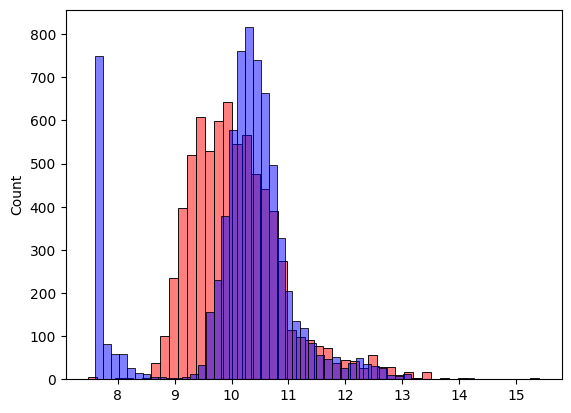

In [72]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)


In [73]:
def rmse(y, y_pred):
    """
    Calculate Root Mean Square Error between actual and predicted values.
    
    Parameters:
    y : numpy array
        Actual values
    y_pred : numpy array
        Predicted values
        
    Returns:
    float: RMSE value
    """
    # Calculate squared error
    se = (y - y_pred) ** 2
    
    # Calculate mean and take square root
    mse = se.mean()
    return np.sqrt(mse)

In [ ]:
rmse(y_train, y_pred)

np.float64(0.7554192603920132)

## 2.10 Validating the model

In [76]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [77]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.7616530991301601)

## 2.11 Simple feature engineering

In [78]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [79]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.5172055461058309)

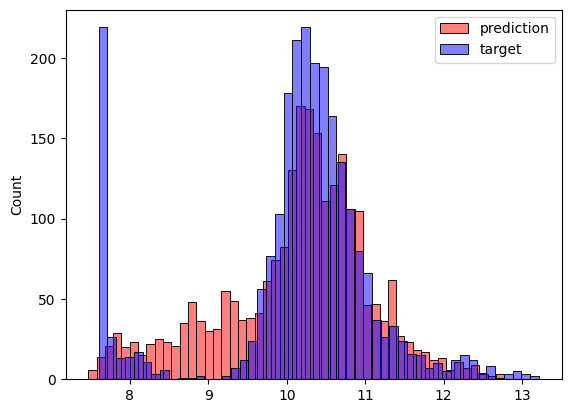

In [80]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

## 2.12 Categorical variables

In [81]:
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head(10).index)

In [82]:
def prepare_X(df):
    """
    Prepare features for model training by:
    1. Adding engineered features (age)
    2. Creating dummy variables for categorical features
    3. Handling missing values
    
    Parameters:
    df : pandas DataFrame
        Input data
        
    Returns:
    numpy array: Processed features matrix
    """
    df = df.copy()
    
    # Feature engineering: Calculate car age
    df['age'] = 2017 - df['year']
    
    # Define base numerical features
    features = base + ['age']  # base defined earlier as key numerical columns
    
    # Create dummy variables for number of doors
    for v in [2, 3, 4]:
        df['num_doors_%d' % v] = (df.number_of_doors == v).astype(int)
        features.append('num_doors_%d' % v)
    
    # Create dummy variables for categorical columns
    # Only keep top categories for each feature to control dimensionality
    for name, values in categorical.items():
        for value in values:
            col_name = '%s_%s' % (name, value)
            df[col_name] = (df[name] == value).astype(int)
            features.append(col_name)
    
    # Select features and handle missing values
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    return df_num.values

In [83]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']

    for v in [2, 3, 4]:
        df['num_doors_%d' % v] = (df.number_of_doors == v).astype(int)
        features.append('num_doors_%d' % v)

    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype(int)
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [84]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(745.8378590366361)

In [85]:
w0, w

(np.float64(-2799.318755828123),
 array([ 1.33107715e-01, -1.00065521e+01, -2.38880640e-01, -3.69894856e+00,
        -1.01831093e-02,  1.29585824e+00,  2.86909335e+03,  2.86344157e+03,
         2.88583577e+03, -2.67802566e+01,  5.56163196e+01, -9.77964956e+00,
         4.11323607e+01,  7.31191985e-01,  2.29072445e+01,  2.23713807e+01,
         7.39771885e+00, -1.00851068e+01,  7.10039872e+01,  2.50681372e+01,
        -5.59376435e+01, -3.43614016e+01, -4.18260097e+01, -6.60837945e+01,
        -6.94159873e+00, -4.14639895e+01, -6.19951928e+00,  1.27001801e+01,
        -1.94457107e+01,  2.33310827e+04,  2.33171428e+04,  2.33190630e+04,
         2.33880340e+04,  2.34735973e+04,  2.39373448e+04,  2.30981746e+04,
         2.31703476e+04,  2.87104476e+04, -2.35345178e+04, -2.35645614e+04,
        -2.35369418e+04, -2.35806870e+04, -7.36987774e+01,  5.29666791e+00,
         9.27593358e+00,  1.33691821e+01,  4.84480882e+00,  5.98722767e+00,
         3.79005123e+01, -2.96286652e-01,  3.89928585e+

## 2.13 Regularization

In [86]:
X = [
    [4, 4, 4],
    [3, 5, 5],
    [5, 1, 1],
    [5, 4, 4],
    [7, 5, 5],
    [4, 5, 5.00000001],
]

X = np.array(X)
X

array([[4.        , 4.        , 4.        ],
       [3.        , 5.        , 5.        ],
       [5.        , 1.        , 1.        ],
       [5.        , 4.        , 4.        ],
       [7.        , 5.        , 5.        ],
       [4.        , 5.        , 5.00000001]])

In [87]:
y= [1, 2, 3, 1, 2, 3]

In [88]:
XTX = X.T.dot(X)
XTX

array([[140.        , 111.        , 111.00000004],
       [111.        , 108.        , 108.00000005],
       [111.00000004, 108.00000005, 108.0000001 ]])

In [89]:
# XTX_inv = np.linalg.inv(XTX)

In [90]:
XTX_inv

array([[ 3.30686958e+00, -5.39612291e-03, -6.21325581e-02,
        -6.61016816e-04],
       [-5.39612291e-03,  1.11633857e-05,  8.66973393e-05,
         1.08664195e-06],
       [-6.21325581e-02,  8.66973393e-05,  1.46189255e-03,
         8.57849603e-06],
       [-6.61016816e-04,  1.08664195e-06,  8.57849603e-06,
         3.60215866e-07]])

In [91]:
# XTX_inv.dot(X.T).dot(y)

In [92]:
XTX = [
    [1, 2, 2],
    [2, 1, 1.0000001],
    [2, 1.0000001, 1]
]

XTX = np.array(XTX)

In [93]:
np.linalg.inv(XTX)

array([[-3.33333356e-01,  3.33333339e-01,  3.33333339e-01],
       [ 3.33333339e-01, -5.00000008e+06,  4.99999991e+06],
       [ 3.33333339e-01,  4.99999991e+06, -5.00000008e+06]])

In [94]:
XTX = XTX + 0.01 * np.eye(3)

In [95]:
def train_linear_regression_reg(X, y, r=0.001):
    """
    Train a linear regression model with L2 regularization (Ridge regression).
    
    Parameters:
    X : numpy array
        Features matrix
    y : numpy array
        Target variable
    r : float
        Regularization parameter (default: 0.001)
        Controls the strength of regularization
        
    Returns:
    tuple: (w0, w) where
        w0 is the bias term (intercept)
        w contains the feature weights (coefficients)
    """
    # Add a column of ones to X for the bias term
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # Calculate weights using the regularized normal equation:
    # w = (X^T X + rI)^-1 X^T y
    XTX = X.T.dot(X)
    
    # Add regularization term (r * Identity matrix)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    # Calculate weights
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    # Split weights into bias (w0) and feature weights (w)
    return w_full[0], w_full[1:]

In [96]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

## Hyperparameter Tuning

We'll try different values of the regularization parameter to find the optimal one that minimizes RMSE on the validation set.

In [97]:
# Try different values for regularization parameter
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    # Train model with current regularization parameter
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    # Make predictions on validation set
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    
    # Calculate RMSE
    score = rmse(y_val, y_pred)
    print(f'r={r:7} : RMSE={score:.6f}')

r=    0.0 : RMSE=745.837859
r=  1e-05 : RMSE=0.442755
r= 0.0001 : RMSE=0.442754
r=  0.001 : RMSE=0.442749
r=    0.1 : RMSE=0.442673
r=      1 : RMSE=0.443603
r=     10 : RMSE=0.457569


In [98]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 -2799.318755828123 745.8378590366361
1e-05 7.062786085234424 0.44275451018234496
0.0001 7.062020986028976 0.4427539054181954
0.001 7.056330521881053 0.4427489846932261
0.1 6.695940767214223 0.4426732377373662
1 5.930966016751146 0.44360259631326854
10 4.654049520840799 0.45756938696410226


## Final Model Training and Evaluation

Train the final model on combined training+validation data using the best regularization parameter, and evaluate it on the test set.

In [99]:
# Combine training and validation data
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

# Prepare features and target
X_full_train = prepare_X(df_full_train)
y_full_train = np.concatenate([y_train, y_val])

# Train final model
r = 0.001  # Best regularization parameter from tuning
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=r)

# Evaluate on test set
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
final_score = rmse(y_test, y_pred)

print(f'Final test RMSE: {final_score:.6f}')

Final test RMSE: 0.440938


In [100]:
df_full_train = pd.concat([df_train, df_val])

In [101]:
df_full_train = df_full_train.reset_index(drop=True)

In [102]:
X_full_train = prepare_X(df_full_train)

In [103]:
X_full_train

array([[148.,   4.,  33., ...,   0.,   0.,   0.],
       [132.,   4.,  32., ...,   0.,   0.,   0.],
       [148.,   4.,  37., ...,   0.,   0.,   0.],
       ...,
       [332.,   8.,  23., ...,   0.,   0.,   0.],
       [148.,   4.,  34., ...,   0.,   0.,   0.],
       [290.,   6.,  25., ...,   0.,   0.,   0.]], shape=(9532, 65))

In [104]:
y_full_train = np.concatenate([y_train, y_val])

In [105]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [106]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

np.float64(0.4409381330279512)

In [107]:
car = df_test.iloc[20].to_dict()
car

{'make': 'Toyota',
 'model': 'Sienna',
 'year': 2015,
 'engine_fuel_type': 'regular unleaded',
 'engine_hp': 266.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'AUTOMATIC',
 'driven_wheels': 'front wheel drive',
 'number_of_doors': 4.0,
 'market_category': nan,
 'vehicle_size': 'Large',
 'vehicle_style': 'Passenger Minivan',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [108]:
df_small = pd.DataFrame([car])
df_small

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,Toyota,Sienna,2015,regular unleaded,266.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Large,Passenger Minivan,25,18,2031


In [109]:
X_small = prepare_X(df_small)

In [110]:
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

np.float64(10.77671614166361)

In [111]:
np.expm1(y_pred)

np.float64(47891.593233586835)

In [112]:
np.expm1(y_test[20])

np.float64(35000.00000000001)

## 2.16 Next steps

* We included only 5 top features. What happens if we include 10?

Other projects

* Predict the price of a house - e.g. boston dataset
* https://archive.ics.uci.edu/ml/datasets.php?task=reg
* https://archive.ics.uci.edu/ml/datasets/Student+Performance

## 2.17 Summary

* EDA - looking at data, finding missing values
* Target variable distribution - long tail => bell shaped curve
* Validation framework: train/val/test split (helped us detect problems)
* Normal equation - not magic, but math
* Implemented it with numpy
* RMSE to validate our model
* Feature engineering: age, categorical features
* Regularization to fight numerical instability